In [32]:
import numpy as np
from env.dis_one_joint import ArmEnv
from utils.util import ReplayMemory
from matplotlib import pyplot as plt
%matplotlib inline

(50, 50, 2)


Text(0, 0.5, 'point_angle')

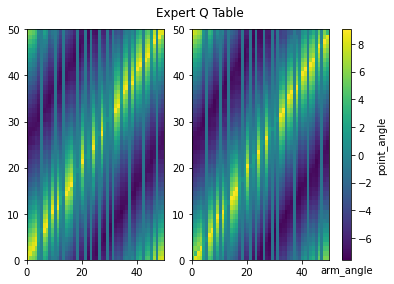

In [33]:
Q_table = np.load("checkpoints/Q_value_initial_table.npy")
print(Q_table.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Expert Q Table')
im1 = ax1.pcolormesh(Q_table[:, :, 0])
im2 = ax2.pcolormesh(Q_table[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

plt.xlabel('arm_angle')
plt.ylabel('point_angle')

Text(0, 0.5, 'point_angle')

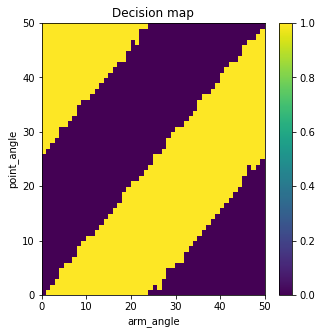

In [34]:
fig = plt.figure(figsize=(5, 5))
plt.title('Decision map')
max_decision = np.argmax(Q_table, axis=2)
im = plt.pcolormesh(max_decision)
cbar = fig.colorbar(im)
plt.xlabel('arm_angle')
plt.ylabel('point_angle')

In [35]:
EP_LEN = 50
expert_len = 50  # number of demonstration
env = ArmEnv(ep_len=EP_LEN)
obs_dim = env.observation_space
action_dim = env.action_dim
seed = 112

# load replay buffer -- state, action, reward, next_state, done
expert_buffer = ReplayMemory(seed=seed, capacity=expert_len*EP_LEN)
expert_buffer.load_buffer("checkpoints/buffer_one_joint_")

Loading buffer from checkpoints/buffer_one_joint_


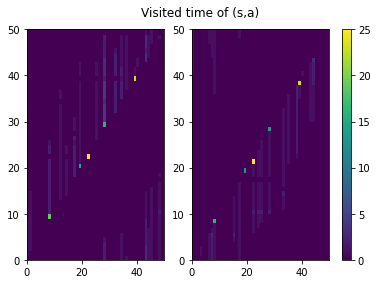

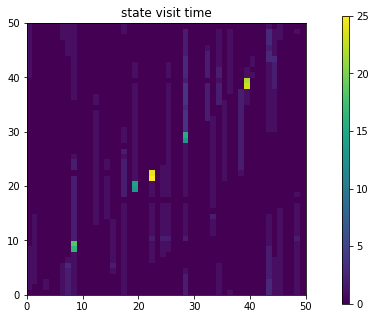

In [36]:
visit_time = np.zeros((obs_dim + [action_dim]))
len_traj = len(expert_buffer.buffer)

for i in range(len_traj):
    state = expert_buffer.buffer[i][0]
    action = expert_buffer.buffer[i][1]
    visit_time[state[0], state[1], action] +=1

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Visited time of (s,a)')
im1 = ax1.pcolormesh(visit_time[:, :, 0])
im2 = ax2.pcolormesh(visit_time[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

fig = plt.figure(figsize=(5, 5))
plt.title('state visit time')
s_visit_time = visit_time.sum(axis=2)
plt.pcolormesh(s_visit_time)
cb_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

In [60]:
# A new q table
TD_Q_table = np.zeros((obs_dim + [action_dim]))
lr = 0.1
gamma = 0.9
update_time = 100

# update the Q table along with the trajectory
# buffer -- state, action, reward, next_state, done
td_errors = []
for batch in range(update_time):
    cum_td_error = 0
    for steps in range(len_traj):
        state = expert_buffer.buffer[steps][0]
        action = expert_buffer.buffer[steps][1]
        reward = expert_buffer.buffer[steps][2]
        next_state = expert_buffer.buffer[steps][3]
        # update Q table
        Q_target = reward + gamma * max(TD_Q_table[next_state[0], next_state[1], :])
        td_error = TD_Q_table[state[0], state[1], action] - Q_target
        TD_Q_table[state[0], state[1], action] -= lr * td_error
        cum_td_error += abs(td_error)
    td_errors.append(cum_td_error/len_traj)

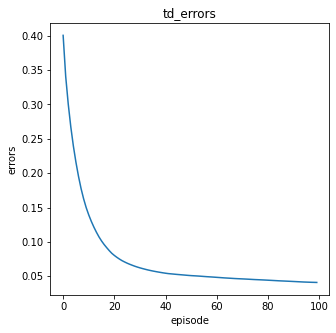

In [61]:
fig = plt.figure(figsize=(5, 5))
plt.title('td_errors')
plt.plot(td_errors)
plt.xlabel('episode')
plt.ylabel('errors')
plt.show()

Text(0, 0.5, 'point_angle')

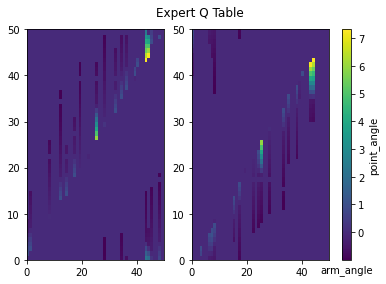

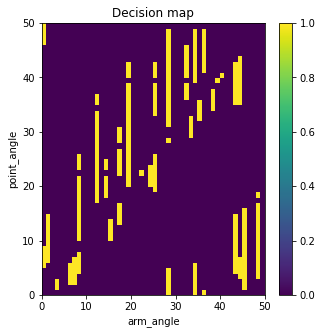

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Expert Q Table')
im1 = ax1.pcolormesh(TD_Q_table[:, :, 0])
im2 = ax2.pcolormesh(TD_Q_table[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

plt.xlabel('arm_angle')
plt.ylabel('point_angle')

fig = plt.figure(figsize=(5, 5))
plt.title('Decision map')
max_decision = np.argmax(TD_Q_table, axis=2)
im = plt.pcolormesh(max_decision)
cbar = fig.colorbar(im)
plt.xlabel('arm_angle')
plt.ylabel('point_angle')

Play with the TD-Q_table

In [63]:
EP_NUM = 10
for i in range(EP_NUM):
 obs = env.reset()
 done = False

 while not done:
  act = np.argmax(TD_Q_table[obs[0], obs[1], :])
  next_obs, reward, done = env.step(act)
  obs = next_obs
  env.render()

KeyboardInterrupt: 

In [67]:
# %% update Q_table
reward_episode = list()
exploration_proba = 0.1
EP_NUM = 10000

for eposide in range(EP_NUM):
    current_state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        if np.random.uniform(0, 1) < exploration_proba:
            action = env.sample_action()
        else:
            action = np.argmax(TD_Q_table[current_state[0], current_state[1], :])

        next_state, reward, done = env.step(action)
        episode_reward += reward

        # update Q table:
        TD_Q_table[current_state[0], current_state[1], action] = (1 - lr) * \
            TD_Q_table[current_state[0], current_state[1], action] + \
            lr * (reward + gamma * max(TD_Q_table[next_state[0], next_state[1], :]))

        current_state = next_state

    reward_episode.append(episode_reward)
    print("epoch %d" % eposide)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
epoch 101
epoch 102
epoch 103
epoch 104
epoch 105
epoch 106
epoch 107
epoch 108
epoch 109
epoch 110


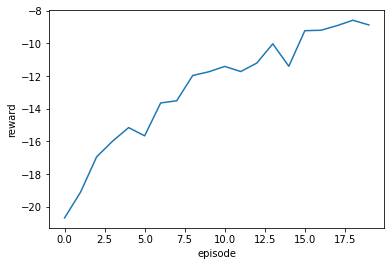

In [68]:
    # average every 500 step
    averaged_reward = list()
    for i in range(len(reward_episode)):
        if (i + 1) % 500 == 0:
            average = np.mean(reward_episode[i - 499:i + 1])
            averaged_reward.append(average)
    plt.plot(averaged_reward)
    plt.xlabel('episode')
    plt.ylabel('reward')
    plt.show()

Text(0, 0.5, 'point_angle')

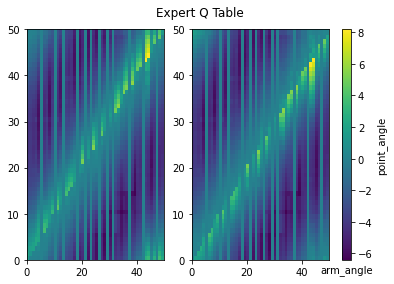

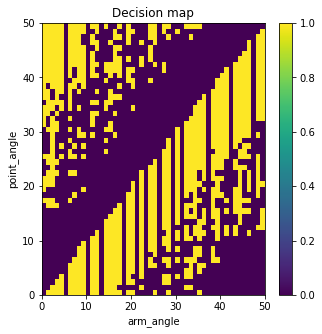

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Expert Q Table')
im1 = ax1.pcolormesh(TD_Q_table[:, :, 0])
im2 = ax2.pcolormesh(TD_Q_table[:, :, 1])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im1, cax=cb_ax)

plt.xlabel('arm_angle')
plt.ylabel('point_angle')

fig = plt.figure(figsize=(5, 5))
plt.title('Decision map')
max_decision = np.argmax(TD_Q_table, axis=2)
im = plt.pcolormesh(max_decision)
cbar = fig.colorbar(im)
plt.xlabel('arm_angle')
plt.ylabel('point_angle')